In [150]:
!pip install torchmetrics torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   -------------------------------------- 179.2/179.2 kB 982.3 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Prepare Data

In [152]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale


import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.functional import binary_f1_score
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler



categories = [
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6"
]

standardize = [
    'LIMIT_BAL',
    'AGE',
    'BILL_AMT1',
    'BILL_AMT2',
    'BILL_AMT3',
    'BILL_AMT4',
    'BILL_AMT5',
    'BILL_AMT6',
    'PAY_AMT1',
    'PAY_AMT2',
    'PAY_AMT3',
    'PAY_AMT4',
    'PAY_AMT5',
    'PAY_AMT6',
]

def read_data():
    df = pd.read_csv("../data/data_participant.csv")
    
    df = df.drop('ID', axis=1)
    
    df = pd.get_dummies(df, columns=categories, drop_first=False)
    
    df[standardize] = scale(df[standardize]) 
    
    return df


df = read_data()
df

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,0.558907,1.140680,-0.596802,-0.679743,-0.671627,-0.491809,-0.508263,-0.708406,-0.293400,-0.238023,...,1,0,0,0,0,0,0,0,0,0
1,-0.674276,-1.354506,-0.681341,-0.688272,-0.542568,-0.670554,-0.664177,-0.657107,-0.341942,0.150424,...,1,0,0,0,0,0,0,0,0,0
2,-1.059646,1.140680,-0.331139,-0.335355,-0.304365,-0.276208,-0.252079,-0.234358,-0.341942,-0.178693,...,0,0,1,0,0,0,0,0,0,0
3,0.327685,-0.812074,1.857396,2.029488,2.025832,1.925627,2.148140,2.274679,0.171250,0.116266,...,0,0,1,0,0,0,0,0,0,0
4,0.481833,0.055816,-0.683039,-0.687021,-0.673862,-0.634771,-0.658420,-0.647989,-0.324916,-0.244750,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-0.443054,-1.137534,0.797188,0.879916,0.882414,0.505894,0.627977,0.711403,0.020312,-0.066889,...,0,0,1,0,0,0,0,0,0,0
29996,-0.905498,-0.812074,-0.313254,-0.291827,-0.280096,-0.239197,-0.193637,-0.162372,-0.255605,-0.180168,...,0,0,1,0,0,0,0,0,0,0
29997,-0.674276,-1.029047,0.277555,0.291797,0.400037,0.504712,0.560654,0.692932,-0.341942,0.003422,...,0,0,0,1,0,0,0,0,0,0
29998,1.483795,-0.703588,0.305966,0.166201,0.039912,-0.472814,-0.588251,-0.487829,-0.032759,0.184841,...,0,1,0,0,0,0,0,0,0,0


In [15]:


OFFICIAL_TEST_SIZE = 6000
OFFICIAL_TEST  = df.iloc[-6000:, :]
OFFICIAL_TRAIN = df.iloc[:-6000, :]

In [18]:
OFFICIAL_TRAIN['default-payment-next-month'].isna().sum()

0

In [19]:
OFFICIAL_TEST['default-payment-next-month'].isna().sum()

6000

In [20]:
train_p = 0.8
test_p = 0.2

rows, cols = OFFICIAL_TRAIN.shape

train_size = int(rows * train_p)
test_size = rows - train_size

df_train = OFFICIAL_TRAIN.iloc[:train_size, :]
df_test =  OFFICIAL_TRAIN.iloc[train_size:, :]

In [25]:
cols = list(df_train.columns)
label = 'default-payment-next-month'
cols.remove(label)
features = cols

In [28]:
x_train = torch.from_numpy(df_train[features].values).float()
y_train = torch.from_numpy(df_train[label].values).float()

x_test = torch.from_numpy(df_test[features].values).float()
y_test = torch.from_numpy(df_test[label].values).float()

# Train

In [115]:
from tqdm import tqdm


def valid(model, x, y):
    loss_fn = nn.BCELoss()  # binary cross entropy
    
    with torch.no_grad():
        prob = model(x).squeeze(dim=1)
        
        loss = loss_fn(prob, y).item()
        
        pred = (prob > 0.5).int()
        
        correct = pred.eq(y.view_as(pred).int()).sum().item()
        
        acc = correct / x.shape[0]

    return loss, acc
    

def train(model, x, y, epochs=100, batch_size=128, lr=0.01, validation=None):
    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    dataset = TensorDataset(
        x,
        y
    )
    
    valid_loss, valid_acc = 0, 0
    
    true_pct = y_test.sum() / y_test.shape[0]
    false_pct = 1  - true_pct
    
    def weight(yy):
        if yy >= 1:
            return false_pct
    
        return true_pct
    
    sampler = WeightedRandomSampler(
        [weight(yy) for yy in y] ,
        y.shape[0]
    )
    
    loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        sampler=sampler
    )
    
    for epoch in range(epochs):
        wloss = 0
        wcnt = 0

        for xin, yout in loader:

            y_pred = model(xin).squeeze(dim=1)
            loss = loss_fn(y_pred, yout)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            wloss += loss.item()
            wcnt += 1

        if validation is not None:
            valid_loss, valid_acc = valid(model, *validation)
            
        loss = (wloss / wcnt)
        print(f"\r{epoch:3d}/{epochs:3d} (loss: {loss:8.4f}) "
              f"(vloss: {valid_loss:.2f}) (vacc: {valid_acc * 100:.2f}%)", 
              end="",
         )


In [109]:
model = nn.Sequential(
    nn.Linear(len(features), 1024), 
    nn.ReLU(), 
    nn.Linear(1024, 512), 
    nn.ReLU(), 
    nn.Linear(512, 1), c
    nn.Sigmoid()
)


valid(model, x_test, y_test)
train(model, x_train, y_train, validation=(x_test, y_test))

 99/100 (loss:   0.5609) (vloss: 0.59) (vacc: 70.79%)

In [116]:
train(model, x_train, y_train, validation=(x_test, y_test), lr=0.001)

 99/100 (loss:   0.5328) (vloss: 0.59) (vacc: 70.56%)

In [130]:
(model(x_test) > 0.5).int().sum()

tensor(1691)

In [131]:
(model(x_test) < 0.5).int().sum()

tensor(3109)

In [132]:
y_test.sum()

tensor(1172.)

In [133]:
y_test.shape[0]

4800

E:\Anaconda\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


binary_f1_score: 50.73


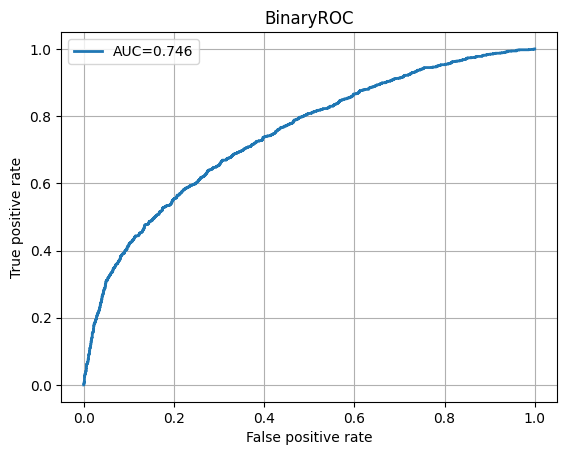

In [161]:
def get_roc(tresh=0.5):
    import torchmetrics

    roc = torchmetrics.classification.BinaryROC()

    with torch.no_grad():
        prob = model(x_test).squeeze(dim=1)

    roc.update(prob, y_test.int())

    print(f"binary_f1_score: {binary_f1_score(prob, y_test.int(), threshold=tresh) * 100:.2f}")
    fig_, ax_ = roc.plot(score=True)
    return fig_
    
    
get_roc()

In [174]:
from math import sqrt

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Sequential(
            nn.Linear(len(features), 1024),
            nn.LayerNorm(1024)
        )
        
        self.a = nn.Linear(1024, 1024)
        self.b = nn.Linear(1024, 1024)
        
        self.out = nn.Sequential(
            nn.ReLU(), 
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        
    def forward(self, x):
        x = self.l1(x)
        
        xa = self.a(x).unsqueeze(1)
        xb = self.b(x).unsqueeze(1)
        
        weight = xa @ xb.transpose(1, 2) / sqrt(1024)
        
        x = x.unsqueeze(1)
        x = (weight @ x).squeeze(1)
        
        return self.out(x)
        
        
model = Model()

  9/ 10 (loss:   0.5754) (vloss: 0.61) (vacc: 67.92%)binary_f1_score: 50.00


E:\Anaconda\lib\site-packages\torchmetrics\utilities\plot.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots() if ax is None else (None, ax)


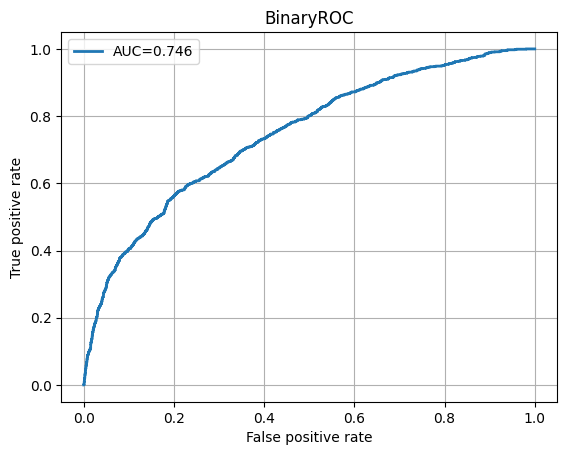

In [175]:
        
model = Model()
train(model, x_train, y_train, epochs=10, validation=(x_test, y_test), lr=0.01)
get_roc()

In [ ]:
train(model, x_train, y_train, epochs=10, validation=(x_test, y_test), lr=0.1)
get_roc()

  0/ 10 (loss:   0.8460) (vloss: 0.66) (vacc: 65.44%)